In [ ]:
#|default_exp tmp

# Upscale + Curriculum

In [ ]:
import pickle,gzip,math,os,time,shutil,torch,random
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
import timm

In [ ]:
from torchvision import transforms
def tfm_batch(b, tfm_x=fc.noop, tfm_y = fc.noop): return tfm_x(b[0]),tfm_y(b[1])

In [ ]:
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = False 

In [ ]:
from miniai.utils import *

In [ ]:
from fastcore.test import test_close
from torch import distributions

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

import logging
logging.disable(logging.WARNING)

set_seed(42)

if fc.defaults.cpus>8: fc.defaults.cpus=8

In [ ]:
p = 0.1
dist = distributions.binomial.Binomial(probs=1-p)
dist.sample((10,))

tensor([1., 1., 1., 1., 1., 1., 0., 1., 1., 1.])

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F  #(uncomment if needed,but you likely already have it)

#Mish - "Mish: A Self Regularized Non-Monotonic Neural Activation Function"
#https://arxiv.org/abs/1908.08681v1
#implemented for PyTorch / FastAI by lessw2020 
#github: https://github.com/lessw2020/mish

class Mish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        #inlining this saves 1 second per epoch (V100 GPU) vs having a temp x and then returning x(!)
        return x *( torch.tanh(F.softplus(x)))

In [ ]:
xl,yl = 'image','label'
name = "fashion_mnist"
bs = 256
xmean,xstd = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

dsd = load_dataset(name)

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
tds = cache_dataset_as_dict(dsd.with_transform(transformi))

In [ ]:
set_seed(42)
lr,epochs = 6e-2,5

In [ ]:
def get_model7(act=nn.ReLU, nfs=(16,32,64,128,256,512), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [nn.Dropout2d(0.2), nn.Flatten(), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers).to(def_device)

In [ ]:
from typing import Iterator
from torch.utils.data import DataLoader, WeightedRandomSampler

class TopLossesCallback(Callback):
    epoch_preds = []
    epoch_targets = []

    @torch.no_grad()
    def _calculate_top_losses(self):
        preds = torch.cat(self.epoch_preds, dim=0)
        targets = torch.cat(self.epoch_targets, dim=0)
        losses = F.cross_entropy(preds, targets, reduce=False)
        return torch.topk(losses, preds.shape[0]).indices

    def after_batch(self, learn):
        if not learn.model.training:
              return
        self.epoch_preds.append(learn.preds)
        self.epoch_targets.append(learn.batch[1])

    def before_epoch(self, learn):
        self.epoch_preds = []
        self.epoch_targets = []

    def after_epoch(self, learn):
        if not learn.model.training:
            return
        learn.dls.train.sampler.top_losses = self._calculate_top_losses()

# tweaked from tommyc's version
# Before certain epoch drop a % of the training dataset with the lowest losses.
# Replace them with the the same % of the training dataset with the highest losses.
# This gives the model two opportunities to train on the most challenging images.
class CustomTrainingSampler(WeightedRandomSampler):
    def __init__(self, *args, **kwargs):
        WeightedRandomSampler.__init__(self, *args, **kwargs)
        self.data_indexes_for_epoch = []
        self.top_losses = []
        self.epoch = -1
        self.n = {
            0: 0,
            1: 0.2,
            2: 0.4,
            3: 0.2,
            4: 0
        }

    def __iter__(self) -> Iterator[int]:
        self.epoch += 1
        rand_tensor = torch.randperm(self.num_samples, generator=self.generator).tolist()
        n = int(self.n[self.epoch] * self.num_samples)

        if n != 0:
            # TODO: Cleanup the code below
            inverted_losses_for_epochs = torch.flip(torch.tensor(self.top_losses.clone().detach()[:n]), dims=(0,)).cpu()
            self.data_indexes_for_epoch = torch.tensor(self.data_indexes_for_epoch).cpu()
            self.data_indexes_for_epoch[self.top_losses[-n:].cpu()] = self.data_indexes_for_epoch[inverted_losses_for_epochs]
            self.data_indexes_for_epoch = self.data_indexes_for_epoch[rand_tensor]
            self.data_indexes_for_epoch = self.data_indexes_for_epoch.tolist()
        else:
            self.data_indexes_for_epoch = rand_tensor

        yield from self.data_indexes_for_epoch


class CustomDataLoaders:
    def __init__(self, *dls): 
        self.train,self.valid = dls[:2]

    def get_sampler(num_samples, mode="train"):
        if mode != "train":
            return None
        return CustomTrainingSampler(weights=[1]*num_samples, num_samples=num_samples)

    @classmethod
    def from_dd(cls, dd, batch_size, as_tuple=True, **kwargs):
        return cls(*[DataLoader(ds, batch_size, sampler=cls.get_sampler(len(ds), mode), collate_fn=collate_dict(ds), **kwargs) for mode, ds in dd.items()])

In [ ]:
# tweaked from rohitgeo's version
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(Mish))
timeit = TimeItCB()
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats, timeit]

# #0.0003 from https://github.com/digantamisra98/Mish/issues/37

In [ ]:

def run(model, leaky, seed=42, m=8, xtra=tuple(), epochs=5, 
        from_dd=DataLoaders.from_dd, lr_sched=lr_scheduler.OneCycleLR, loss=F.cross_entropy):
    iw = partial(init_weights, leaky=0.0003)
    set_seed(seed)

    model = model.apply(iw)

    lr = 1e-2 *m
    dls = from_dd(tds, bs*m, num_workers=0)
    tmax = epochs * len(dls.train)
    sched = partial(lr_sched, max_lr=lr, total_steps=tmax)
    xtra = [BatchSchedCB(sched)]+xtra
    
    print ('batchsize', dls.train.batch_size, xtra)
    learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
    if epochs: learn.fit(epochs)
    return learn

## resize images for resnet properly


In [ ]:
def upscale_cb(scale, mode='bilinear'): 
    return BatchTransformCB(lambda b: (F.interpolate(b[0], scale_factor=scale, mode=mode),b[1]),
                            on_val=True, on_train=True)

## Upscale 2x + curriculum learning

batchsize 1024 [<miniai.sgd.BatchSchedCB object>, <miniai.init.BatchTransformCB object>]


accuracy,loss,epoch,train
0.786,0.648,0,train
0.351,8.694,0,eval
0.900,0.274,1,train
0.887,0.312,1,eval
0.927,0.198,2,train
0.913,0.235,2,eval
0.946,0.147,3,train
0.930,0.201,3,eval
0.963,0.102,4,train
0.936,0.184,4,eval


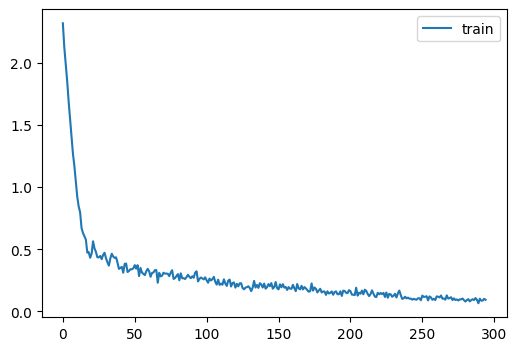

Fit 5 in: 60.25s, setup: 0.00s, 11.69 ± 0.27s per epoch, 0.13 ± 0.01s per batch


In [ ]:
learn = run(timm.create_model('resnet18d', in_chans=1, num_classes=10, act_layer=nn.SiLU, pretrained=False), 
            leaky=0.0003,
            xtra=[upscale_cb(2, 'nearest')], m=4)

batchsize 1024 [<miniai.sgd.BatchSchedCB object>, <miniai.init.BatchTransformCB object>, <miniai.init.BatchTransformCB object>]


accuracy,loss,epoch,train
0.721,0.823,0,train
0.309,9.177,0,eval
0.854,0.407,1,train
0.875,0.348,1,eval
0.899,0.275,2,train
0.906,0.256,2,eval
0.911,0.241,3,train
0.910,0.240,3,eval
0.926,0.200,4,train
0.924,0.207,4,eval


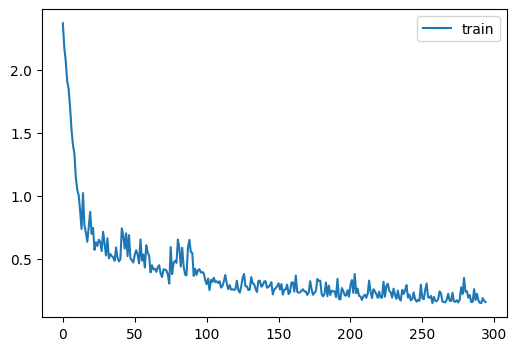

Fit 5 in: 59.71s, setup: 0.00s, 11.58 ± 0.27s per epoch, 0.13 ± 0.02s per batch


In [ ]:
tfms = [transforms.RandomHorizontalFlip(), transforms.RandomErasing()]
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=nn.Sequential(*tfms)), on_val=False)
learn = run(timm.create_model('resnet18d', in_chans=1, num_classes=10, act_layer=nn.SiLU, pretrained=False), 
            leaky=0.0003, xtra=[upscale_cb(2, 'nearest'), augcb], m=4)

In [ ]:
# TTA
ap1, at = learn.capture_preds()
ttacb = BatchTransformCB(partial(tfm_batch, tfm_x=TF.hflip), on_val=True)
ap2, at = learn.capture_preds(cbs=[ttacb])
ap = torch.stack([ap1,ap2]).mean(0).argmax(1)
print(round((ap==at).float().mean().item(), 3))

accuracy,loss,epoch,train
0.924,0.207,0,eval


Fit 0 in: 0.67s, setup: 0.01s, nan ± nans per epoch, nan ± nans per batch


/home/piotr/workspace/part2/course22p2/miniai/utils.py:53: RuntimeWarning: Mean of empty slice.
  return f"{stats.mean():.2f} ± {stats.std():.2f}"
/home/piotr/miniconda3/envs/miniai/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/piotr/miniconda3/envs/miniai/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/piotr/miniconda3/envs/miniai/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/piotr/miniconda3/envs/miniai/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


accuracy,loss,epoch,train
0.924,0.207,0,eval


Fit 0 in: 0.37s, setup: 0.02s, nan ± nans per epoch, nan ± nans per batch
0.924


In [ ]:
#|export
def _rand_erase1(x, pct, xm, xs, mn, mx):
    szx = int(pct*x.shape[-2])
    szy = int(pct*x.shape[-1])
    stx = int(random.random()*(1-pct)*x.shape[-2])
    sty = int(random.random()*(1-pct)*x.shape[-1])
    init.normal_(x[:,:,stx:stx+szx,sty:sty+szy], mean=xm, std=xs)
    x.clamp_(mn, mx)
def rand_erase(x, pct=0.2, max_num = 4):
    xm,xs,mn,mx = x.mean(),x.std(),x.min(),x.max()
    num = random.randint(0, max_num)
    for i in range(num): _rand_erase1(x, pct, xm, xs, mn, mx)
#     print(num)
    return x
class RandErase(nn.Module):
    def __init__(self, pct=0.2, max_num=4):
        super().__init__()
        self.pct,self.max_num = pct,max_num
    def forward(self, x): return rand_erase(x, self.pct, self.max_num)

In [ ]:
transforms.RandomErasing??

batchsize 1024 [<miniai.sgd.BatchSchedCB object>, <miniai.init.BatchTransformCB object>, <miniai.init.BatchTransformCB object>]


accuracy,loss,epoch,train
0.732,0.773,0,train
0.729,1.559,0,eval
0.868,0.360,1,train
0.870,0.375,1,eval
0.901,0.266,2,train
0.897,0.301,2,eval
0.924,0.206,3,train
0.911,0.241,3,eval
0.935,0.176,4,train
0.928,0.196,4,eval


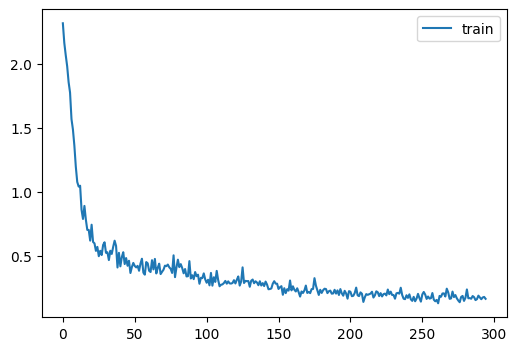

Fit 5 in: 59.76s, setup: 0.00s, 11.60 ± 0.22s per epoch, 0.13 ± 0.01s per batch


In [ ]:
tfms = [transforms.RandomHorizontalFlip(), RandErase()]
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=nn.Sequential(*tfms)), on_val=False)
learn = run(timm.create_model('resnet18d', in_chans=1, num_classes=10, act_layer=nn.SiLU, pretrained=False), 
            leaky=0.0003, xtra=[upscale_cb(2, 'nearest'), augcb], m=4)

In [ ]:
transforms.RandomHorizontalFlip??

batchsize 1024 [<miniai.sgd.BatchSchedCB object>, <miniai.init.BatchTransformCB object>, <__main__.TopLossesCallback object>]


accuracy,loss,epoch,train
0.786,0.644,0,train
0.763,1.198,0,eval
0.844,0.422,1,train
0.882,0.323,1,eval
0.811,0.478,2,train
0.916,0.235,2,eval
0.906,0.244,3,train
0.930,0.285,3,eval
0.986,0.042,4,train
0.936,0.248,4,eval


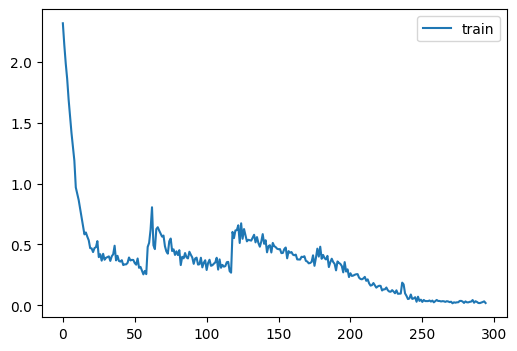

/tmp/ipykernel_24684/4257131880.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inverted_losses_for_epochs = torch.flip(torch.tensor(self.top_losses.clone().detach()[:n]), dims=(0,)).cpu()


Fit 5 in: 60.66s, setup: 0.00s, 11.76 ± 0.39s per epoch, 0.13 ± 0.02s per batch


In [ ]:
learn = run(timm.create_model('resnet18d', in_chans=1, num_classes=10, act_layer=nn.SiLU, pretrained=False), 
            leaky=0.0003,
            from_dd=CustomDataLoaders.from_dd,
            xtra=[upscale_cb(2, 'nearest'), TopLossesCallback()], m=4)

## OneCycle Wiht Plateau

In [ ]:
class OneCycleLRWithPlateau(lr_scheduler.OneCycleLR):
    def __init__(self, *args, pct_start=0.1, pct_plateau=0.2, **kwargs):
        kwargs["pct_start"] = pct_start
        super(OneCycleLRWithPlateau, self).__init__(*args, **kwargs)
        self._schedule_phases = [
            {
                'end_step': float(pct_start * self.total_steps) - 1,
                'start_lr': 'initial_lr',
                'end_lr': 'max_lr',
                'start_momentum': 'max_momentum',
                'end_momentum': 'base_momentum',
            },
            {
                'end_step': float((pct_start + pct_plateau) * self.total_steps) - 2,
                'start_lr': 'max_lr',
                'end_lr': 'max_lr',
                'start_momentum': 'base_momentum',
                'end_momentum': 'base_momentum',
            },
            {
                'end_step': self.total_steps - 1,
                'start_lr': 'max_lr',
                'end_lr': 'initial_lr',
                'start_momentum': 'base_momentum',
                'end_momentum': 'max_momentum',
            },
        ]

batchsize 1024 [<miniai.sgd.BatchSchedCB object>, <miniai.init.BatchTransformCB object>]


accuracy,loss,epoch,train
0.779,0.631,0,train
0.769,0.868,0,eval
0.904,0.261,1,train
0.861,0.375,1,eval
0.924,0.206,2,train
0.900,0.289,2,eval
0.942,0.158,3,train
0.929,0.197,3,eval
0.959,0.109,4,train
0.938,0.181,4,eval


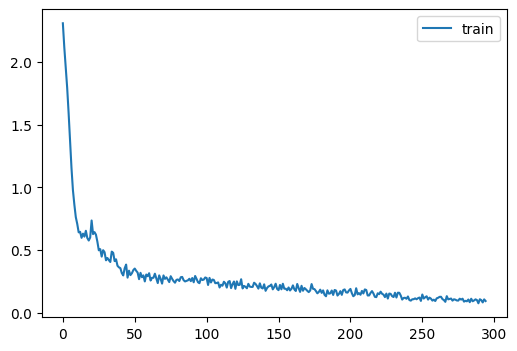

Fit 5 in: 60.20s, setup: 0.00s, 11.68 ± 0.32s per epoch, 0.13 ± 0.02s per batch


In [ ]:
learn = run(timm.create_model('resnet18d', in_chans=1, num_classes=10, act_layer=nn.SiLU, pretrained=False), 
            leaky=0.0003, xtra=[upscale_cb(2, 'nearest')], m=4, 
            lr_sched=partial(OneCycleLRWithPlateau, pct_start=0.1, pct_plateau=0.3))

In [ ]:
### hflip TTA without hflip

In [ ]:
ap1, at = learn.capture_preds()
ttacb = BatchTransformCB(partial(tfm_batch, tfm_x=TF.hflip), on_val=True)
ap2, at = learn.capture_preds(cbs=[ttacb])
ap = torch.stack([ap1,ap2]).mean(0).argmax(1)
print(round((ap==at).float().mean().item(), 3))

accuracy,loss,epoch,train
0.938,0.181,0,eval


Fit 0 in: 0.38s, setup: 0.02s, nan ± nans per epoch, nan ± nans per batch


accuracy,loss,epoch,train
0.771,1.277,0,eval


Fit 0 in: 0.38s, setup: 0.02s, nan ± nans per epoch, nan ± nans per batch
0.928


batchsize 1024 [<miniai.sgd.BatchSchedCB object>, <miniai.init.BatchTransformCB object>, <miniai.init.BatchTransformCB object>]


accuracy,loss,epoch,train
0.772,0.665,0,train
0.794,0.604,0,eval
0.897,0.279,1,train
0.713,1.073,1,eval
0.917,0.224,2,train
0.886,0.324,2,eval
0.934,0.179,3,train
0.924,0.205,3,eval
0.948,0.139,4,train
0.933,0.185,4,eval


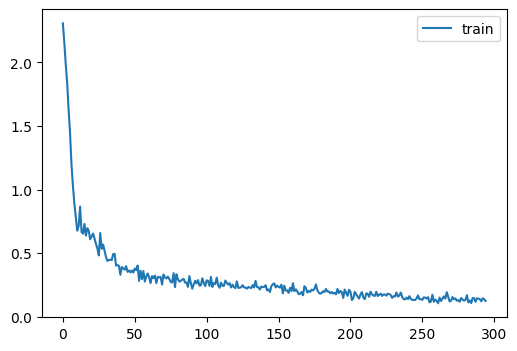

Fit 5 in: 60.29s, setup: 0.00s, 11.70 ± 0.23s per epoch, 0.13 ± 0.02s per batch


In [ ]:
tfms = nn.Sequential( transforms.RandomHorizontalFlip())
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)
learn = run(timm.create_model('resnet18d', in_chans=1, num_classes=10, act_layer=nn.SiLU, pretrained=False), 
            leaky=0.0003, xtra=[upscale_cb(2, 'nearest'), augcb], m=4, 
            lr_sched=partial(OneCycleLRWithPlateau, pct_start=0.1, pct_plateau=0.3))

In [ ]:
# TTA
ap1, at = learn.capture_preds()
ttacb = BatchTransformCB(partial(tfm_batch, tfm_x=TF.hflip), on_val=True)
ap2, at = learn.capture_preds(cbs=[ttacb])
ap = torch.stack([ap1,ap2]).mean(0).argmax(1)
print(round((ap==at).float().mean().item(), 3))

accuracy,loss,epoch,train
0.933,0.185,0,eval


Fit 0 in: 0.57s, setup: 0.02s, nan ± nans per epoch, nan ± nans per batch


accuracy,loss,epoch,train
0.932,0.183,0,eval


Fit 0 in: 0.37s, setup: 0.02s, nan ± nans per epoch, nan ± nans per batch
0.935


batchsize 256 [<miniai.sgd.BatchSchedCB object>, <miniai.init.BatchTransformCB object>]


accuracy,loss,epoch,train
0.768,0.713,0,train
0.861,0.397,0,eval
0.898,0.284,1,train
0.894,0.295,1,eval
0.924,0.210,2,train
0.919,0.219,2,eval
0.946,0.151,3,train
0.938,0.173,3,eval
0.966,0.098,4,train
0.944,0.164,4,eval


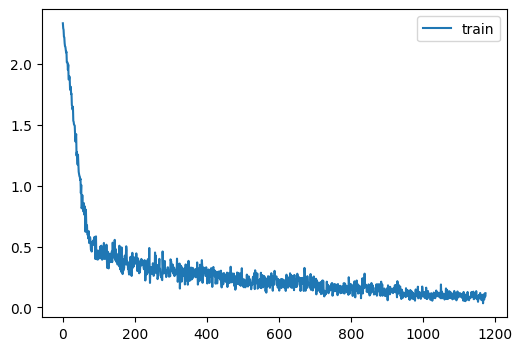

Fit 5 in: 208.50s, setup: 0.00s, 40.42 ± 0.93s per epoch, 0.11 ± 0.04s per batch


In [ ]:
learn = run(timm.create_model('resnet18d', in_chans=1, num_classes=10, act_layer=nn.SiLU,  drop_rate=0.6), m=1, 
            leaky=0.0003, xtra=[upscale_cb(4, 'nearest')])

batchsize 256 [<miniai.sgd.BatchSchedCB object>, <miniai.init.BatchTransformCB object>, <miniai.init.BatchTransformCB object>]


accuracy,loss,epoch,train
0.762,0.735,0,train
0.858,0.433,0,eval
0.892,0.302,1,train
0.873,0.379,1,eval
0.919,0.227,2,train
0.922,0.216,2,eval
0.936,0.175,3,train
0.934,0.182,3,eval
0.953,0.131,4,train
0.940,0.171,4,eval


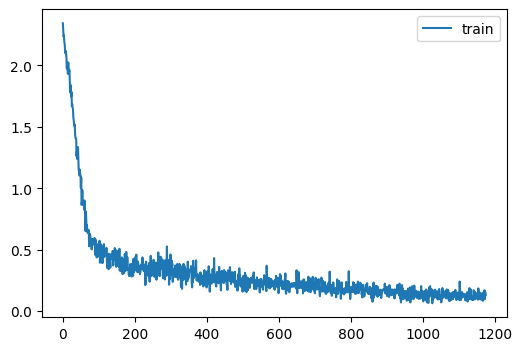

Fit 5 in: 207.43s, setup: 0.00s, 40.38 ± 0.66s per epoch, 0.10 ± 0.01s per batch


In [ ]:
tfms = nn.Sequential( transforms.RandomHorizontalFlip())
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)
learn = run(timm.create_model('resnet18d', in_chans=1, num_classes=10, act_layer=nn.SiLU,  drop_rate=0.6), m=1, 
            leaky=0.0003, xtra=[upscale_cb(4, 'nearest'), augcb])

In [ ]:
# TTA
ap1, at = learn.capture_preds()
ttacb = BatchTransformCB(partial(tfm_batch, tfm_x=TF.hflip), on_val=True)
ap2, at = learn.capture_preds(cbs=[ttacb])
ap = torch.stack([ap1,ap2]).mean(0).argmax(1)
print(round((ap==at).float().mean().item(), 3))

accuracy,loss,epoch,train
0.940,0.171,0,eval


Fit 0 in: 1.22s, setup: 0.00s, nan ± nans per epoch, nan ± nans per batch


accuracy,loss,epoch,train
0.939,0.171,0,eval


Fit 0 in: 1.20s, setup: 0.00s, nan ± nans per epoch, nan ± nans per batch
0.941


batchsize 256 [<miniai.sgd.BatchSchedCB object>, <miniai.init.BatchTransformCB object>, <miniai.init.BatchTransformCB object>]


accuracy,loss,epoch,train
0.788,0.627,0,train
0.859,0.398,0,eval
0.903,0.271,1,train
0.899,0.282,1,eval
0.920,0.225,2,train
0.902,0.284,2,eval
0.936,0.177,3,train
0.936,0.177,3,eval
0.955,0.128,4,train
0.940,0.166,4,eval


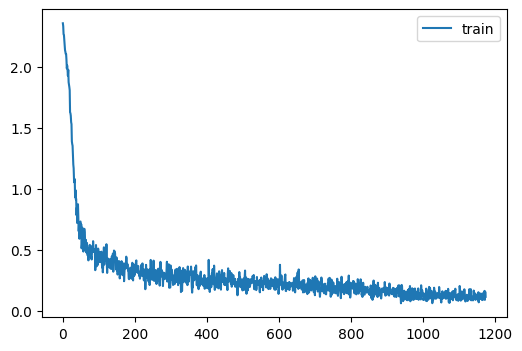

Fit 5 in: 206.23s, setup: 0.00s, 40.14 ± 0.57s per epoch, 0.10 ± 0.01s per batch


In [ ]:
tfms = nn.Sequential( transforms.RandomHorizontalFlip())
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)
learn = run(timm.create_model('resnet18d', in_chans=1, num_classes=10, act_layer=nn.SiLU,  drop_rate=0.6), m=1, 
            leaky=0.0003, xtra=[upscale_cb(4, 'nearest'), augcb],
            lr_sched=partial(OneCycleLRWithPlateau, pct_start=0.1, pct_plateau=0.3))


In [ ]:
# TTA
ap1, at = learn.capture_preds()
ttacb = BatchTransformCB(partial(tfm_batch, tfm_x=TF.hflip), on_val=True)
ap2, at = learn.capture_preds(cbs=[ttacb])
ap = torch.stack([ap1,ap2]).mean(0).argmax(1)
print(round((ap==at).float().mean().item(), 3))

accuracy,loss,epoch,train
0.940,0.166,0,eval


Fit 0 in: 1.18s, setup: 0.00s, nan ± nans per epoch, nan ± nans per batch


accuracy,loss,epoch,train
0.941,0.167,0,eval


Fit 0 in: 1.17s, setup: 0.00s, nan ± nans per epoch, nan ± nans per batch
0.942


# all together


batchsize 256 [<miniai.sgd.BatchSchedCB object>, <miniai.init.BatchTransformCB object>, <__main__.TopLossesCallback object>]


accuracy,loss,epoch,train
0.790,0.661,0,train
0.859,0.421,0,eval
0.861,0.375,1,train
0.911,0.248,1,eval
0.854,0.387,2,train
0.923,0.247,2,eval
0.959,0.117,3,train
0.940,0.284,3,eval
0.999,0.007,4,train
0.941,0.254,4,eval


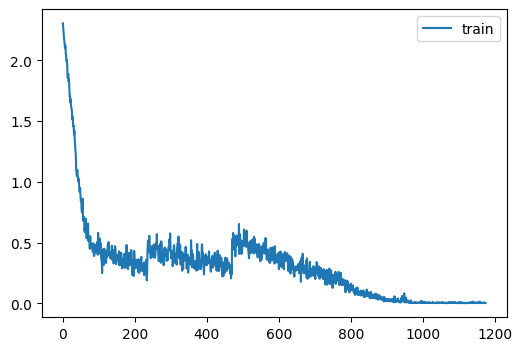

/home/piotr/miniconda3/envs/miniai/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
/tmp/ipykernel_27210/4257131880.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inverted_losses_for_epochs = torch.flip(torch.tensor(self.top_losses.clone().detach()[:n]), dims=(0,)).cpu()


Fit 5 in: 206.46s, setup: 0.00s, 40.11 ± 0.27s per epoch, 0.10 ± 0.00s per batch


In [ ]:
learn = run(timm.create_model('resnet18d', in_chans=1, num_classes=10, act_layer=nn.SiLU, pretrained=False), 
            leaky=0.0003,
            from_dd=CustomDataLoaders.from_dd,
            xtra=[upscale_cb(4, 'nearest'), TopLossesCallback()], m=1)

batchsize 256 [<miniai.sgd.BatchSchedCB object>, <miniai.init.BatchTransformCB object>, <__main__.TopLossesCallback object>, <miniai.init.BatchTransformCB object>]


accuracy,loss,epoch,train
0.784,0.629,0,train
0.862,0.391,0,eval
0.853,0.398,1,train
0.881,0.343,1,eval
0.805,0.512,2,train
0.921,0.228,2,eval
0.865,0.348,3,train
0.930,0.247,3,eval
0.984,0.046,4,train
0.942,0.196,4,eval


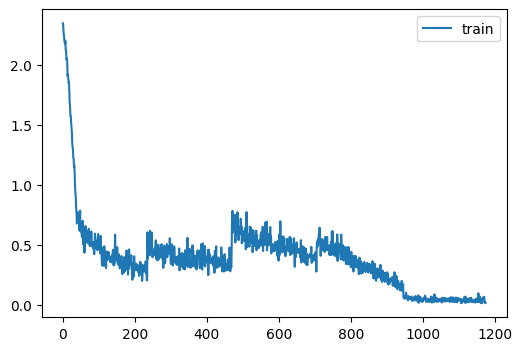

/tmp/ipykernel_27210/4257131880.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inverted_losses_for_epochs = torch.flip(torch.tensor(self.top_losses.clone().detach()[:n]), dims=(0,)).cpu()


Fit 5 in: 206.73s, setup: 0.00s, 40.17 ± 0.45s per epoch, 0.10 ± 0.00s per batch


In [ ]:
tfms = nn.Sequential( transforms.RandomHorizontalFlip())
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)
learn = run(timm.create_model('resnet18d', in_chans=1, num_classes=10, act_layer=nn.SiLU,  drop_rate=0.6), m=1, 
            leaky=0.0003, xtra=[upscale_cb(4, 'nearest'), TopLossesCallback(), augcb],
            from_dd=CustomDataLoaders.from_dd,
            lr_sched=partial(OneCycleLRWithPlateau, pct_start=0.1, pct_plateau=0.3))


# Label smoothing for resnet18d


batchsize 256 [<miniai.sgd.BatchSchedCB object>, <miniai.init.BatchTransformCB object>]


accuracy,loss,epoch,train
0.768,0.713,0,train
0.861,0.397,0,eval
0.898,0.284,1,train
0.894,0.295,1,eval
0.924,0.210,2,train
0.919,0.219,2,eval
0.946,0.151,3,train
0.938,0.173,3,eval
0.966,0.098,4,train
0.944,0.164,4,eval


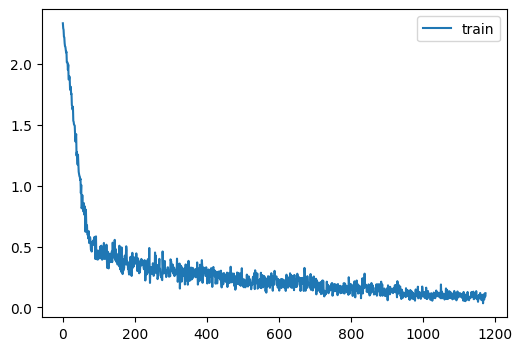

Fit 5 in: 208.50s, setup: 0.00s, 40.42 ± 0.93s per epoch, 0.11 ± 0.04s per batch


In [ ]:
learn = run(timm.create_model('resnet18d', in_chans=1, num_classes=10, act_layer=nn.SiLU,  drop_rate=0.6), 
            m=1, leaky=0.0003, xtra=[upscale_cb(4, 'nearest')], loss=nn.CrossEntropyLoss(label_smoothing=0.0))

batchsize 256 [<miniai.sgd.BatchSchedCB object>, <miniai.init.BatchTransformCB object>]


accuracy,loss,epoch,train
0.769,0.711,0,train
0.872,0.364,0,eval
0.899,0.282,1,train
0.884,0.322,1,eval
0.924,0.209,2,train
0.928,0.206,2,eval
0.947,0.149,3,train
0.939,0.170,3,eval
0.967,0.095,4,train
0.944,0.164,4,eval


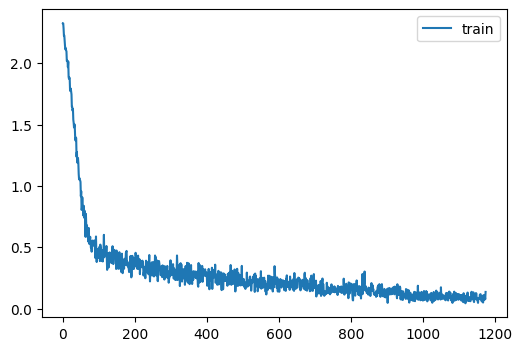

Fit 5 in: 205.40s, setup: 0.00s, 39.98 ± 0.48s per epoch, 0.10 ± 0.01s per batch


In [ ]:
learn = run(timm.create_model('resnet18d', in_chans=1, num_classes=10, act_layer=nn.SiLU,  drop_rate=0.6), 
            m=1, leaky=0.0003, xtra=[upscale_cb(4, 'nearest')], loss=nn.CrossEntropyLoss(label_smoothing=0.1))

batchsize 256 [<miniai.sgd.BatchSchedCB object>, <miniai.init.BatchTransformCB object>]


accuracy,loss,epoch,train
0.768,0.712,0,train
0.879,0.361,0,eval
0.898,0.285,1,train
0.868,0.376,1,eval
0.924,0.210,2,train
0.923,0.216,2,eval
0.945,0.151,3,train
0.937,0.179,3,eval
0.965,0.100,4,train
0.941,0.171,4,eval


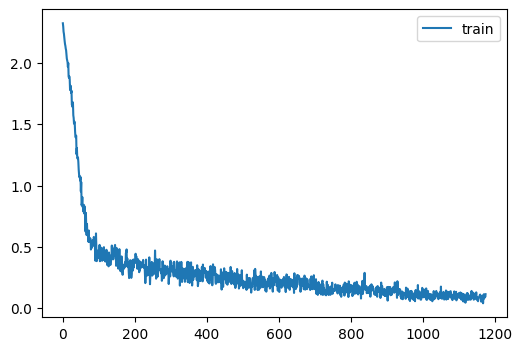

Fit 5 in: 206.08s, setup: 0.00s, 40.11 ± 0.41s per epoch, 0.10 ± 0.00s per batch


In [ ]:
learn = run(timm.create_model('resnet18d', in_chans=1, num_classes=10, act_layer=nn.SiLU,  drop_rate=0.6), 
            m=1, leaky=0.0003, xtra=[upscale_cb(4, 'nearest')], loss=nn.CrossEntropyLoss(label_smoothing=0.2))

## resnet34d

batchsize 256 [<miniai.sgd.BatchSchedCB object>, <miniai.init.BatchTransformCB object>]


accuracy,loss,epoch,train
0.747,0.768,0,train
0.709,1.084,0,eval
0.900,0.283,1,train
0.912,0.247,1,eval
0.925,0.208,2,train
0.896,0.296,2,eval
0.946,0.151,3,train
0.938,0.173,3,eval
0.967,0.093,4,train
0.943,0.167,4,eval


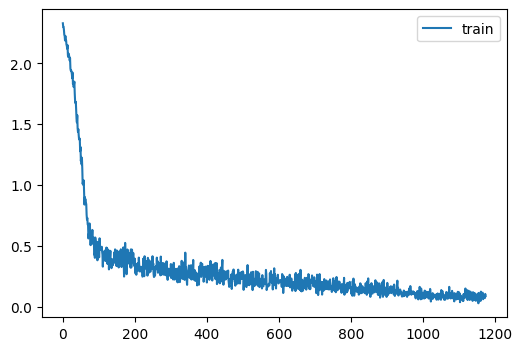

Fit 5 in: 276.87s, setup: 0.00s, 53.65 ± 0.50s per epoch, 0.16 ± 0.01s per batch


In [ ]:
learn = run(timm.create_model('resnet34d', in_chans=1, num_classes=10, act_layer=nn.SiLU,  drop_rate=0.6), m=1, 
            leaky=0.0003, xtra=[upscale_cb(4, 'nearest')], loss=nn.CrossEntropyLoss(label_smoothing=0.1))

batchsize 256 [<miniai.sgd.BatchSchedCB object>, <miniai.init.BatchTransformCB object>, <miniai.init.BatchTransformCB object>]


accuracy,loss,epoch,train
0.726,0.806,0,train
0.838,0.498,0,eval
0.892,0.300,1,train
0.904,0.268,1,eval
0.918,0.228,2,train
0.912,0.254,2,eval
0.937,0.174,3,train
0.933,0.191,3,eval
0.952,0.133,4,train
0.939,0.173,4,eval


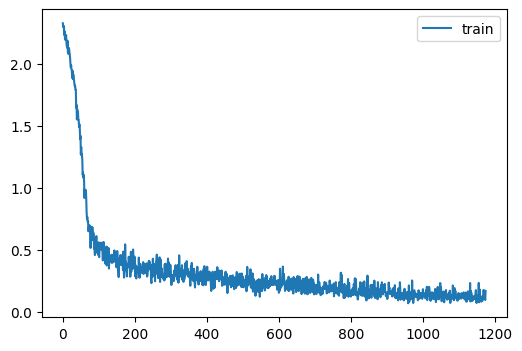

Fit 5 in: 276.64s, setup: 0.00s, 53.59 ± 0.44s per epoch, 0.16 ± 0.01s per batch


In [ ]:
tfms = nn.Sequential( transforms.RandomHorizontalFlip())
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)
learn = run(timm.create_model('resnet34d', in_chans=1, num_classes=10, act_layer=nn.SiLU,  drop_rate=0.6), m=1, 
            leaky=0.0003, xtra=[upscale_cb(4, 'nearest'), augcb], loss=nn.CrossEntropyLoss(label_smoothing=0.1))

In [ ]:
# TTA
ap1, at = learn.capture_preds()
ttacb = BatchTransformCB(partial(tfm_batch, tfm_x=TF.hflip), on_val=True)
ap2, at = learn.capture_preds(cbs=[ttacb])
ap = torch.stack([ap1,ap2]).mean(0).argmax(1)
print(round((ap==at).float().mean().item(), 3))

accuracy,loss,epoch,train
0.939,0.173,0,eval


Fit 0 in: 1.83s, setup: 0.00s, nan ± nans per epoch, nan ± nans per batch


/home/piotr/workspace/part2/course22p2/miniai/utils.py:53: RuntimeWarning: Mean of empty slice.
  return f"{stats.mean():.2f} ± {stats.std():.2f}"
/home/piotr/miniconda3/envs/miniai/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/piotr/miniconda3/envs/miniai/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/piotr/miniconda3/envs/miniai/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/piotr/miniconda3/envs/miniai/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


accuracy,loss,epoch,train
0.938,0.176,0,eval


Fit 0 in: 1.81s, setup: 0.00s, nan ± nans per epoch, nan ± nans per batch
0.94


batchsize 256 [<miniai.sgd.BatchSchedCB object>, <miniai.init.BatchTransformCB object>, <__main__.TopLossesCallback object>, <miniai.init.BatchTransformCB object>]


accuracy,loss,epoch,train
0.768,0.668,0,train
0.863,0.397,0,eval
0.859,0.385,1,train
0.848,0.439,1,eval
0.809,0.500,2,train
0.911,0.247,2,eval
0.867,0.347,3,train
0.934,0.229,3,eval
0.986,0.041,4,train
0.941,0.206,4,eval


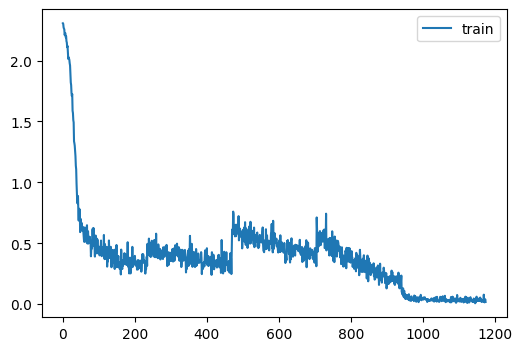

/home/piotr/miniconda3/envs/miniai/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
/tmp/ipykernel_28153/4257131880.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inverted_losses_for_epochs = torch.flip(torch.tensor(self.top_losses.clone().detach()[:n]), dims=(0,)).cpu()


Fit 5 in: 275.49s, setup: 0.00s, 53.28 ± 0.47s per epoch, 0.16 ± 0.01s per batch


In [ ]:
tfms = nn.Sequential( transforms.RandomHorizontalFlip())
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)
learn = run(timm.create_model('resnet34d', in_chans=1, num_classes=10, act_layer=nn.SiLU,  drop_rate=0.6), m=1, 
            leaky=0.0003, xtra=[upscale_cb(4, 'nearest'), TopLossesCallback(), augcb],
            from_dd=CustomDataLoaders.from_dd, loss=nn.CrossEntropyLoss(label_smoothing=0.1),
            lr_sched=partial(OneCycleLRWithPlateau, pct_start=0.1, pct_plateau=0.3))

In [ ]:
# TTA
ap1, at = learn.capture_preds()
ttacb = BatchTransformCB(partial(tfm_batch, tfm_x=TF.hflip), on_val=True)
ap2, at = learn.capture_preds(cbs=[ttacb])
ap = torch.stack([ap1,ap2]).mean(0).argmax(1)
print(round((ap==at).float().mean().item(), 3))

accuracy,loss,epoch,train
0.941,0.206,0,eval


Fit 0 in: 1.86s, setup: 0.00s, nan ± nans per epoch, nan ± nans per batch


/home/piotr/workspace/part2/course22p2/miniai/utils.py:53: RuntimeWarning: Mean of empty slice.
  return f"{stats.mean():.2f} ± {stats.std():.2f}"
/home/piotr/miniconda3/envs/miniai/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/piotr/miniconda3/envs/miniai/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/piotr/miniconda3/envs/miniai/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/piotr/miniconda3/envs/miniai/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


accuracy,loss,epoch,train
0.941,0.207,0,eval


Fit 0 in: 1.85s, setup: 0.00s, nan ± nans per epoch, nan ± nans per batch
0.945


# resnet 50

batchsize 256 [<miniai.sgd.BatchSchedCB object>, <miniai.init.BatchTransformCB object>]


accuracy,loss,epoch,train
0.774,0.672,0,train
0.692,1.325,0,eval
0.889,0.309,1,train
0.898,0.294,1,eval
0.918,0.230,2,train
0.919,0.220,2,eval
0.937,0.176,3,train
0.932,0.190,3,eval
0.956,0.122,4,train
0.938,0.177,4,eval


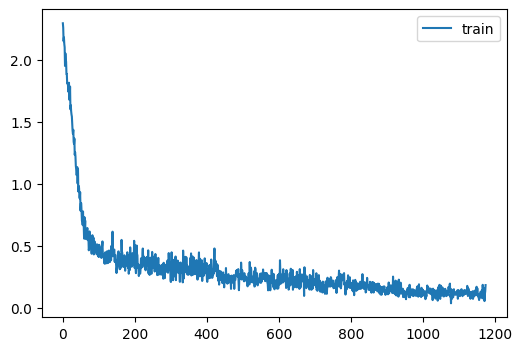

Fit 5 in: 470.20s, setup: 0.00s, 90.47 ± 4.74s per epoch, 0.32 ± 0.04s per batch


In [ ]:
learn = run(timm.create_model('resnet50d', in_chans=1, num_classes=10, act_layer=nn.SiLU,  drop_rate=0.6), m=1, 
            leaky=0.0003, xtra=[upscale_cb(4, 'nearest')], loss=nn.CrossEntropyLoss(label_smoothing=0.1))

batchsize 256 [<miniai.sgd.BatchSchedCB object>, <miniai.init.BatchTransformCB object>, <__main__.TopLossesCallback object>, <miniai.init.BatchTransformCB object>]


accuracy,loss,epoch,train
0.780,0.637,0,train
0.836,0.567,0,eval
0.837,0.444,1,train
0.829,0.597,1,eval
0.765,0.611,2,train
0.912,0.241,2,eval
0.793,0.516,3,train
0.929,0.217,3,eval
0.970,0.082,4,train
0.939,0.193,4,eval


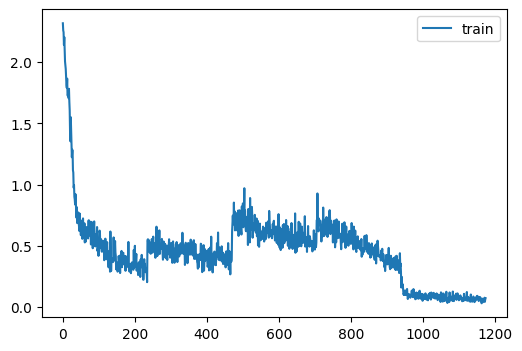

/home/piotr/miniconda3/envs/miniai/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
/tmp/ipykernel_28757/4257131880.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inverted_losses_for_epochs = torch.flip(torch.tensor(self.top_losses.clone().detach()[:n]), dims=(0,)).cpu()


Fit 5 in: 469.12s, setup: 0.00s, 90.47 ± 5.25s per epoch, 0.32 ± 0.08s per batch


In [ ]:
tfms = nn.Sequential( transforms.RandomHorizontalFlip())
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)
learn = run(timm.create_model('resnet50d', in_chans=1, num_classes=10, act_layer=nn.SiLU,  drop_rate=0.6), m=1, 
            leaky=0.0003, xtra=[upscale_cb(4, 'nearest'), TopLossesCallback(), augcb],
            from_dd=CustomDataLoaders.from_dd, loss=nn.CrossEntropyLoss(label_smoothing=0.1),
            lr_sched=partial(OneCycleLRWithPlateau, pct_start=0.1, pct_plateau=0.3))

In [ ]:
# resnet 32d 50 epoch

batchsize 1024 [<miniai.sgd.BatchSchedCB object>, <miniai.init.BatchTransformCB object>]


accuracy,loss,epoch,train
0.757,0.724,0,train
0.767,0.821,0,eval
0.895,0.289,1,train
0.878,0.351,1,eval
0.913,0.244,2,train
0.826,0.530,2,eval
0.920,0.222,3,train
0.880,0.394,3,eval
0.925,0.207,4,train
0.903,0.314,4,eval


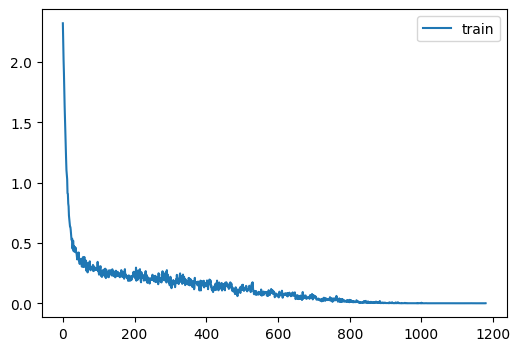

Fit 20 in: 240.98s, setup: 0.00s, 11.69 ± 0.17s per epoch, 0.13 ± 0.01s per batch


In [ ]:
learn = run(timm.create_model('resnet18d', in_chans=1, num_classes=10, act_layer=nn.SiLU,  drop_rate=0.6), m=4, 
            leaky=0.0003, xtra=[upscale_cb(2, 'nearest')], loss=nn.CrossEntropyLoss(label_smoothing=0.1), epochs=20)

batchsize 1024 [<miniai.sgd.BatchSchedCB object>, <miniai.init.BatchTransformCB object>]


accuracy,loss,epoch,train
0.694,0.907,0,train
0.652,1.842,0,eval
0.888,0.305,1,train
0.873,0.418,1,eval
0.911,0.249,2,train
0.688,1.296,2,eval
0.915,0.234,3,train
0.880,0.406,3,eval
0.921,0.215,4,train
0.861,0.439,4,eval


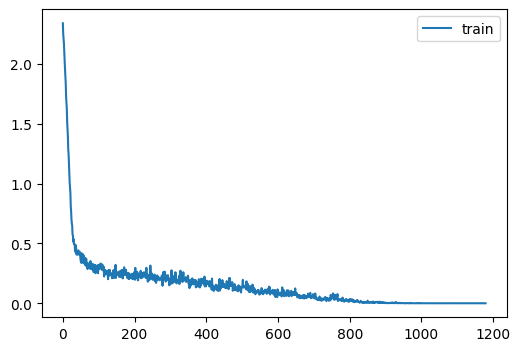

Fit 20 in: 327.47s, setup: 0.00s, 15.80 ± 0.18s per epoch, 0.20 ± 0.01s per batch


In [ ]:
learn = run(timm.create_model('resnet34d', in_chans=1, num_classes=10, act_layer=nn.SiLU,  drop_rate=0.6), m=4, 
            leaky=0.0003, xtra=[upscale_cb(2, 'nearest')], loss=nn.CrossEntropyLoss(label_smoothing=0.1), epochs=20)

batchsize 1024 [<miniai.sgd.BatchSchedCB object>, <miniai.init.BatchTransformCB object>, <miniai.init.BatchTransformCB object>]


accuracy,loss,epoch,train
0.677,0.971,0,train
0.770,0.957,0,eval
0.877,0.331,1,train
0.854,0.426,1,eval
0.901,0.273,2,train
0.836,0.507,2,eval
0.910,0.251,3,train
0.874,0.382,3,eval
0.913,0.242,4,train
0.480,4.204,4,eval


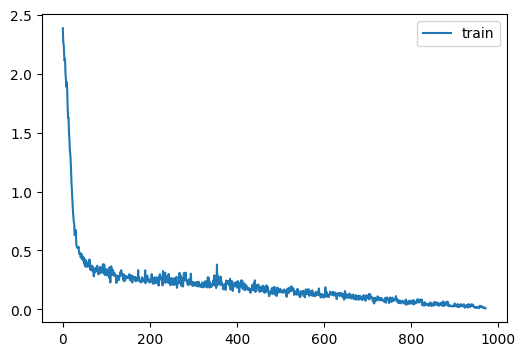

In [ ]:
tfms = nn.Sequential( transforms.RandomHorizontalFlip())
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)
learn = run(timm.create_model('resnet34d', in_chans=1, num_classes=10, act_layer=nn.SiLU,  drop_rate=0.6), m=4, 
            leaky=0.0003, xtra=[upscale_cb(2, 'nearest'), augcb], loss=nn.CrossEntropyLoss(label_smoothing=0.1), epochs=20)

In [ ]:
learn = run(timm.create_model('resnet34d', in_chans=1, num_classes=10, act_layer=nn.SiLU,  drop_rate=0.6), m=1, 
            leaky=0.0003, xtra=[upscale_cb(4, 'nearest')], loss=nn.CrossEntropyLoss(label_smoothing=0.1), epochs=50)